# Testing the sinkhole detectibility power
@author: Max Felius

## Roadmap - Determine Statistics and Errors from simulation
- Create initialization set of epochs with only noise
- Create set with epochs with signal
- Determine sigma for each point from the initialization set
- Type I error: 
    - Apply least square to retrieve the 'scaling factor'
    - Extract ehat and determine the OMT
    - Test OMT with Chi2 distribution
- Type II error:
    - Determine detectability Power for each point
    - Multiply the power of each point to obtain one overall value
    
## NOTES
- Dataset will be stored in a pandas dataframe

In [31]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random

In [147]:
def zg(R,r):
    return np.exp(-np.pi*(r**2/R**2))

def sinkhole_deformation(day,v,R,r,noise):
    return np.array([random.gauss(0,noise) for _ in range(len(r))]) + v*day*zg(R,r)

def WLSE(R,r,y,t):
    w = np.eye(len(r))
    A = t*zg(R,r)
    
    Qxx = np.linalg.inv(A.T @ w @ A)
    xhat = Qxx @ A.T @ w @ y
    
#     yhat = A @ xhat
    return xhat

def BLUE(R,r,y,t,sigma):
    w = np.linalg.inv(np.eye(len(r))*sigma**2)
    A = t*zg(R,r)
    
    Qxx = np.linalg.inv(np.array(A.T @ w @ A).reshape((1,1)))
    
#     print(Qxx.shape,A.reshape((len(r),1)).T,w.shape,y.reshape((len(r),1)))
    
    A = A.reshape((len(r),1))
    y = y.reshape((len(r),1))

    xhat = Qxx @ A.T @ w @ y

#     yhat = A @ xhat
    return xhat

In [105]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 0.00031 #[m/day]
R_wink2016_gaus = 555 # [m]
delta_days = np.array([12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 0
y0 = 0

#noise
mu = 0
sigma = 0.003

#Define the sinkhole grid
n = 20
r = np.array([x**2 for x in range(n)])

In [107]:
# Create initialization set of epochs with only noise
header_init = ['Epoch 1','Epoch 2','Epoch 3','Epoch 4','Epoch 5','Epoch 6','Epoch 7','Epoch 8','Epoch 9','Epoch 10']
df = pd.DataFrame(np.zeros((n,len(header_init))),columns=header_init)

#create nxlen(header_init) array
for header in header_init:
    df[header] = [random.gauss(mu,sigma) for _ in range(n)]
    
#add the sigma of each row
df_sigma = pd.DataFrame(np.zeros((n,1)),columns=['Sigma_init [m]'])
for row in range(n):
    df_sigma['Sigma_init [m]'].iloc[row] = np.std(df.iloc[row])
    
#join datasets
df = df_sigma.join(df)

#join radius
df_radius = pd.DataFrame(r.T,columns=['Radius [m]'])
df = df_radius.join(df)

#Create dataset with sinkhole signal
epochs = [str(x) for x in delta_days]
df_signal = pd.DataFrame(np.zeros((n,len(epochs))),columns=epochs)

for day in delta_days:
    df_signal[str(day)] = sinkhole_deformation(day,v_wink2016_gaus,R_wink2016_gaus,r,sigma)
    
#combine datasets
df = df.join(df_signal)

In [154]:
R = 550
t_array= np.array([])
r_array= np.array([])
y_array= np.array([])

xhat_save = []

for days in delta_days:
    y = df[str(days)].values
    r = df['Radius [m]'].values
    t = np.array([days]*len(r))

    t_array = np.concatenate((t_array,t))
    y_array = np.concatenate((y_array,y))
    r_array = np.concatenate((r_array,r))
    
    xhat = BLUE(R,r_array,y_array,t_array,sigma)
    xhat_save.append(xhat[0][0])

In [168]:
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

In [178]:
def detectability_power(sigma,z):
    m1 = 0
    std1 = sigma
    std2 = sigma
    dec_pow = []

    for m2 in z_idx:
        result = solve(m1,m2,std1,std2)
        intersect = result[0]
        area = 1-(norm.cdf(intersect,m2,std2) + (1-norm.cdf(intersect,m1,std1)))
        dec_pow.append(area)
    return dec_pow

0.4217799298429009
0.7126538162024721
0.8223509535794407
0.8824757190135966
0.9321387471417065
0.9565443614401147
0.9799209779018762
0.9870609063459538
0.9916461477343462
0.9944753311311876


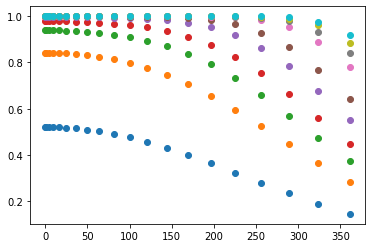

In [186]:
plt.figure()
for i in range(len(xhat_save)):
    zidx = i
    r = df['Radius [m]'].values
    z_idx = xhat_save[zidx]*delta_days[zidx]*zg(R,r)
    dec_pow2 = detectability_power(sigma,z_idx)

    plt.scatter(r,dec_pow2)

    print(np.mean(dec_pow2))

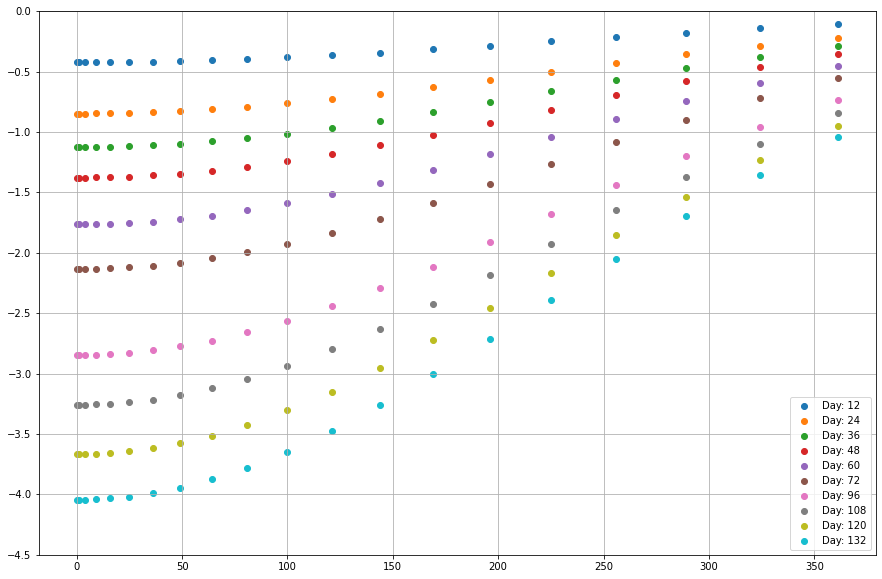

In [165]:
plt.figure(figsize=(15,10))

for idx,ixhat in enumerate(xhat_save):
    r = df['Radius [m]'].values
    z = -100*ixhat*delta_days[idx]*zg(R,r)
    plt.scatter(r,z,label=f'Day: {delta_days[idx]}')
    plt.ylim([-4.5,0])

plt.legend()
plt.grid(True);

In [87]:
df

,Radius [m],Sigma_init [m],Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,...,12,24,36,48,60,72,96,108,120,132
0,0,0.003263,0.007349,0.001239,-0.001674,-0.002353,-0.002850,0.000482,0.005547,0.002719,...,0.007785,0.007061,0.013428,0.017646,0.018431,0.029296,0.029350,0.032839,0.041373,0.043773
1,1,0.002621,-0.001276,-0.000452,-0.001742,0.004899,-0.003148,0.003932,-0.000472,0.002377,...,-0.002248,0.005682,0.013122,0.014273,0.021767,0.022485,0.029750,0.030609,0.037089,0.043884
2,4,0.002947,0.004847,-0.002293,0.003370,-0.003646,-0.000135,-0.003060,-0.004982,0.001275,...,-0.000726,0.006369,0.013037,0.019730,0.016989,0.023336,0.029462,0.040534,0.040384,0.039136
3,9,0.003051,0.002090,0.002135,0.006123,0.000841,-0.005000,0.001740,-0.001384,-0.001684,...,0.004536,0.011690,0.008330,0.016650,0.018295,0.022773,0.033341,0.031996,0.036667,0.043497
4,16,0.002502,-0.002689,0.001740,0.003276,-0.000440,-0.000591,0.000569,0.001131,-0.005943,...,0.002974,0.010538,0.011552,0.015410,0.020165,0.020511,0.033510,0.029313,0.036012,0.042179
5,25,0.004445,0.004002,-0.006837,-0.002455,0.003025,0.004129,0.006538,0.003229,-0.003093,...,0.003068,0.005348,0.010255,0.013014,0.018464,0.022169,0.029236,0.032572,0.035779,0.041926
6,36,0.002293,0.000828,0.003610,0.003467,-0.000286,-0.000015,0.003421,0.000514,0.003644,...,0.004479,0.007810,0.005726,0.014588,0.015257,0.023868,0.030666,0.038221,0.034140,0.040933
7,49,0.002440,-0.006399,-0.000568,0.000664,-0.000358,0.000892,-0.002876,-0.004504,-0.004389,...,0.001910,0.008343,0.010203,0.010805,0.019503,0.021249,0.029930,0.032806,0.038522,0.041365
8,64,0.002154,0.001003,0.003222,-0.004508,-0.000136,-0.001895,-0.000110,-0.000449,-0.000716,...,0.000786,0.013702,0.009224,0.015134,0.022330,0.019827,0.027736,0.033370,0.034356,0.042527
9,81,0.003263,0.005046,-0.001715,-0.000068,0.001870,-0.001909,-0.004019,-0.000618,0.003656,...,0.001394,0.008135,0.010876,0.014758,0.017490,0.022141,0.028188,0.031573,0.035520,0.034837
